```{contents}
```
## State Validation

**State Validation** ensures that every update flowing through a LangGraph execution **conforms to the declared state schema**, preserving correctness, safety, and predictability across complex multi-node and multi-agent workflows.

---

### **1. Motivation and Intuition**

LangGraph systems coordinate many nodes over long-running executions.
Without validation, corrupted or malformed state can silently propagate and break the entire workflow.

| Risk Without Validation | Consequence             |
| ----------------------- | ----------------------- |
| Unexpected keys         | Node crashes later      |
| Wrong data types        | Subtle logic bugs       |
| Missing fields          | Incomplete decisions    |
| Corrupted memory        | Unrecoverable execution |
| Security leaks          | Sensitive data exposure |

State validation provides **formal guarantees** about data integrity.

---

### **2. Conceptual Model**

```
Node Output ──► Validation ──► State Update ──► Next Node
                  │
               (Reject / Error)
```

Only **validated updates** are merged into the global state.

---

### **3. How State Validation Works**

LangGraph uses a **typed schema** (usually `TypedDict` or Pydantic) as the contract.

```python
from typing import TypedDict

class State(TypedDict):
    query: str
    plan: str
    result: str
```

Every node must return a **partial update** consistent with this schema.

```python
def planner(state: State):
    plan = build_plan(state["query"])
    return {"plan": plan}        # validated against State
```

If a node returns:

```python
return {"unknown_key": 123}
```

Execution fails immediately with a **state validation error**.

---

### **4. What Is Validated**

| Property               | Enforced                   |
| ---------------------- | -------------------------- |
| Field existence        | Must be declared in schema |
| Type correctness       | Must match declared type   |
| Key names              | No undeclared fields       |
| Partial update safety  | Only allowed fields        |
| Structural consistency | Across entire run          |

---

### **5. Validation in Execution Flow**

| Step              | Action                        |
| ----------------- | ----------------------------- |
| Node executes     | Produces local output         |
| Validation layer  | Checks schema compliance      |
| Reducer merges    | Applies safe update           |
| Checkpoint stored | Only validated state persists |

This prevents **invalid state from ever entering memory**.

---

### **6. Demonstration**



In [9]:
from pydantic import BaseModel, ValidationError
from langgraph.graph import StateGraph, END

class State(BaseModel):
    x: int
    y: int

    class Config:
        extra = "forbid"

def strict_reducer(left: State, right: dict) -> State:
    # Force validation on every update
    merged = {**left.model_dump(), **right}
    return State(**merged)

def add(state: State):
    return {"x": state.x + 1}

def bad_node(state: State):
    return {"z": 99}   # ❌ Now this WILL fail

builder = StateGraph(State)

builder.add_node("add", add)
builder.add_node("bad", bad_node)

# builder.add_node("x", strict_reducer)
# builder.add_node("y", strict_reducer)

builder.set_entry_point("add")
builder.add_edge("add", "bad")
builder.add_edge("bad", END)

graph = builder.compile()
graph.invoke({"x": 1, "y": 2})


C:\Users\sangouda\AppData\Local\Temp\ipykernel_37420\4131217327.py:4: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  class State(BaseModel):


{'x': 2, 'y': 2}

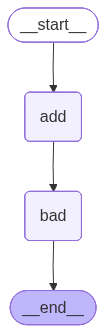

In [10]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png()   )



**Result**

```
StateValidationError: Key 'z' not allowed by State schema
```

Execution stops safely before corruption occurs.

---

### **7. Validation with Complex Types**

```python
class State(TypedDict):
    user_id: str
    scores: list[int]
    meta: dict[str, float]
```

Every node update is checked for:

* List element type
* Dictionary key/value type
* Required vs optional fields

---

### **8. State Validation in Cycles & Agents**

In cyclic and multi-agent systems:

* Each iteration validates new updates
* Prevents error accumulation
* Ensures memory consistency across loops
* Makes long-running agents reliable

---

### **9. Local Node State vs Validation**

| Aspect          | Local Node State | Global State       |
| --------------- | ---------------- | ------------------ |
| Validated       | ❌ No             | ✅ Yes              |
| Persisted       | ❌ No             | ✅ Yes              |
| Schema-enforced | ❌ No             | ✅ Yes              |
| Failure impact  | Local only       | Global correctness |

Local variables can be anything; **only returned updates are validated**.

---

### **10. Performance Considerations**

| Design Choice       | Effect                |
| ------------------- | --------------------- |
| Small schema        | Faster validation     |
| Partial updates     | Minimal overhead      |
| Local heavy objects | Avoid validation cost |
| Structured types    | Safer & faster        |

Validation overhead is negligible compared to LLM/tool execution.

---

### **11. Production Benefits**

| Property        | Benefit              |
| --------------- | -------------------- |
| Determinism     | Predictable behavior |
| Fault isolation | Fail fast            |
| Observability   | Clear error origin   |
| Security        | Prevent data leakage |
| Maintainability | Strong contracts     |

---

### **12. Key Design Principle**

> **State schema is the contract of your entire system.
> If it is correct, your LangGraph system is correct.**

State Validation is therefore the **foundation of reliability, safety, and scalability** in LangGraph.
